# Deep Dive: Lipschitz Hardness vs. LSH Performance

**Objective:**
We have identified that $L=80, k=4$ is a high-performing configuration for our JL+LSH pipeline.
In this notebook, we re-run this specific configuration across multiple target dimensions ($d \in \{32, 48, 96, 120\}$) to analyze the relationship between the **Theoretical Hardness Score ($H$)** and the empirical failure rate.

**Hypothesis:**
Queries with a high Hardness Score ($H$) are inherently "unstable" and will fail more often, regardless of the dimension.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.random_projection import GaussianRandomProjection
import sys
import os

# Add parent directory to path to import your modules
sys.path.append(os.getcwd()) 

try:
    from final import calculate_relative_hardness, E2LSH
    from datasets import DatasetLoader
    print(" Imports successful!")
except ImportError as e:
    print(f" Import Error: {e}")

 Imports successful!


## 1. Experiment Configuration
We fix the LSH parameters and sweep over the JL dimensions.

In [57]:
# Fixed LSH Params (Best Found)
FIXED_L = 150
FIXED_K = 20
LSH_R = 4.0  # Must match final.py logic

# JL Dimensions to Test
DIMENSIONS_TO_TEST = [32, 64]

# Data Params
DATASET_NAME = 'gist'
N_TEST = 1000
DATA_DIR = 'data'

# Storage for results
all_experiment_data = {}

## 2. Load Data & Ground Truth
We load the data once and compute the "True" nearest neighbor in the original 128D space. This is our baseline.

In [58]:
loader = DatasetLoader(data_dir=DATA_DIR)
X_train_orig, X_test_orig = loader.load_dataset(DATASET_NAME, n_test=N_TEST)

print(f"Loaded {DATASET_NAME}: Train {X_train_orig.shape}, Test {X_test_orig.shape}")

# Compute Ground Truth (True Distance 'c')
print("Computing Ground Truth in Original Space...")
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='euclidean').fit(X_train_orig)
true_dists, true_indices = nbrs.kneighbors(X_test_orig)
true_dists = true_dists.flatten()
true_indices = true_indices.flatten()

Loading GIST-1M dataset...
  Training: (1000000, 960) (dtype: float32)
  Test: (1000, 960) (dtype: float32)
Loaded gist: Train (1000000, 960), Test (1000, 960)
Computing Ground Truth in Original Space...


## 3. Run Experiments Loop
For each dimension $d$:
1. Project Data using JL.
2. Build LSH Index ($L=80, k=4$).
3. Query and record Success/Failure.
4. Compute Hardness $H$ for that query.
5. Save.

In [59]:
# =========================================================
# FAST VERSION: Checks Hash Collisions directly (No Index Building)
# =========================================================

# 1. Pre-compute Hardness 
print("Pre-computing Hardness scores...")
hardness_cache = []
for c in true_dists[:N_TEST]:
    hardness_cache.append(calculate_relative_hardness(c, LSH_R))

# 2. Run Fast Experiment
for d in DIMENSIONS_TO_TEST:
    print(f"\n{'='*40}\nRunning FAST Experiment: d={d}\n{'='*40}")
    
    # --- Projection ---
    if d < X_train_orig.shape[1]:
        jl = GaussianRandomProjection(n_components=d, eps=0.1, random_state=42)
        X_train_proj = jl.fit_transform(X_train_orig)
        X_test_proj = jl.transform(X_test_orig)
    else:
        X_train_proj = X_train_orig
        X_test_proj = X_test_orig

    # --- Initialize LSH (But DON'T call fit!) ---
    # We only need the hash functions (projections/offsets), not the populated tables.
    lsh = E2LSH(num_tables=FIXED_L, hash_bits=FIXED_K, dim=d, r=LSH_R)
    
    dimension_results = []
    
    print("  Checking Collisions (Simulation)...")
    for i in range(N_TEST):
        true_idx = true_indices[i]
        
        # Get Vectors
        query_vec = X_test_proj[i]
        true_nn_vec = X_train_proj[true_idx] # Direct access to NN vector
        
        # Check Collision across ALL tables at once
        collision_found = False
        for table_idx in range(FIXED_L):
            # Compute hash signatures directly
            # Note: _compute_hash returns array, we tuple-ize it for comparison
            h_query = tuple(lsh._compute_hash(query_vec, table_idx)[0])
            h_nn    = tuple(lsh._compute_hash(true_nn_vec, table_idx)[0])
            
            if h_query == h_nn:
                collision_found = True
                break # Success! Found in at least one table.
        
        # Categorize for Visualization
        if collision_found:
            outcome_type = "In Pool"
            is_success = 1
        else:
            outcome_type = "Not in Pool"
            is_success = 0

        dimension_results.append({
            'query_idx': i,
            'dimension': d,
            'true_dist': true_dists[i],
            'hardness_H': hardness_cache[i], # Use cached score
            'success': is_success,
            'outcome_category': outcome_type, # <--- Added for Visualization
            'pool_size': -1 # Unknown in simulation, but not needed for your plots
        })

    # Store results
    df_dim = pd.DataFrame(dimension_results)
    all_experiment_data[d] = df_dim
    print(f"  -> Finished d={d}. Recall: {df_dim['success'].mean():.2%}")

Pre-computing Hardness scores...

Running FAST Experiment: d=32
  Checking Collisions (Simulation)...
  -> Finished d=32. Recall: 67.20%

Running FAST Experiment: d=64
  Checking Collisions (Simulation)...
  -> Finished d=64. Recall: 67.10%


## 4. Visualizations
We now create the two key charts for each dimension:
1. **Confidence Curve:** How probability of success drops as H increases.
2. **Predictor Separation:** The distribution of H for Successes vs. Failures.

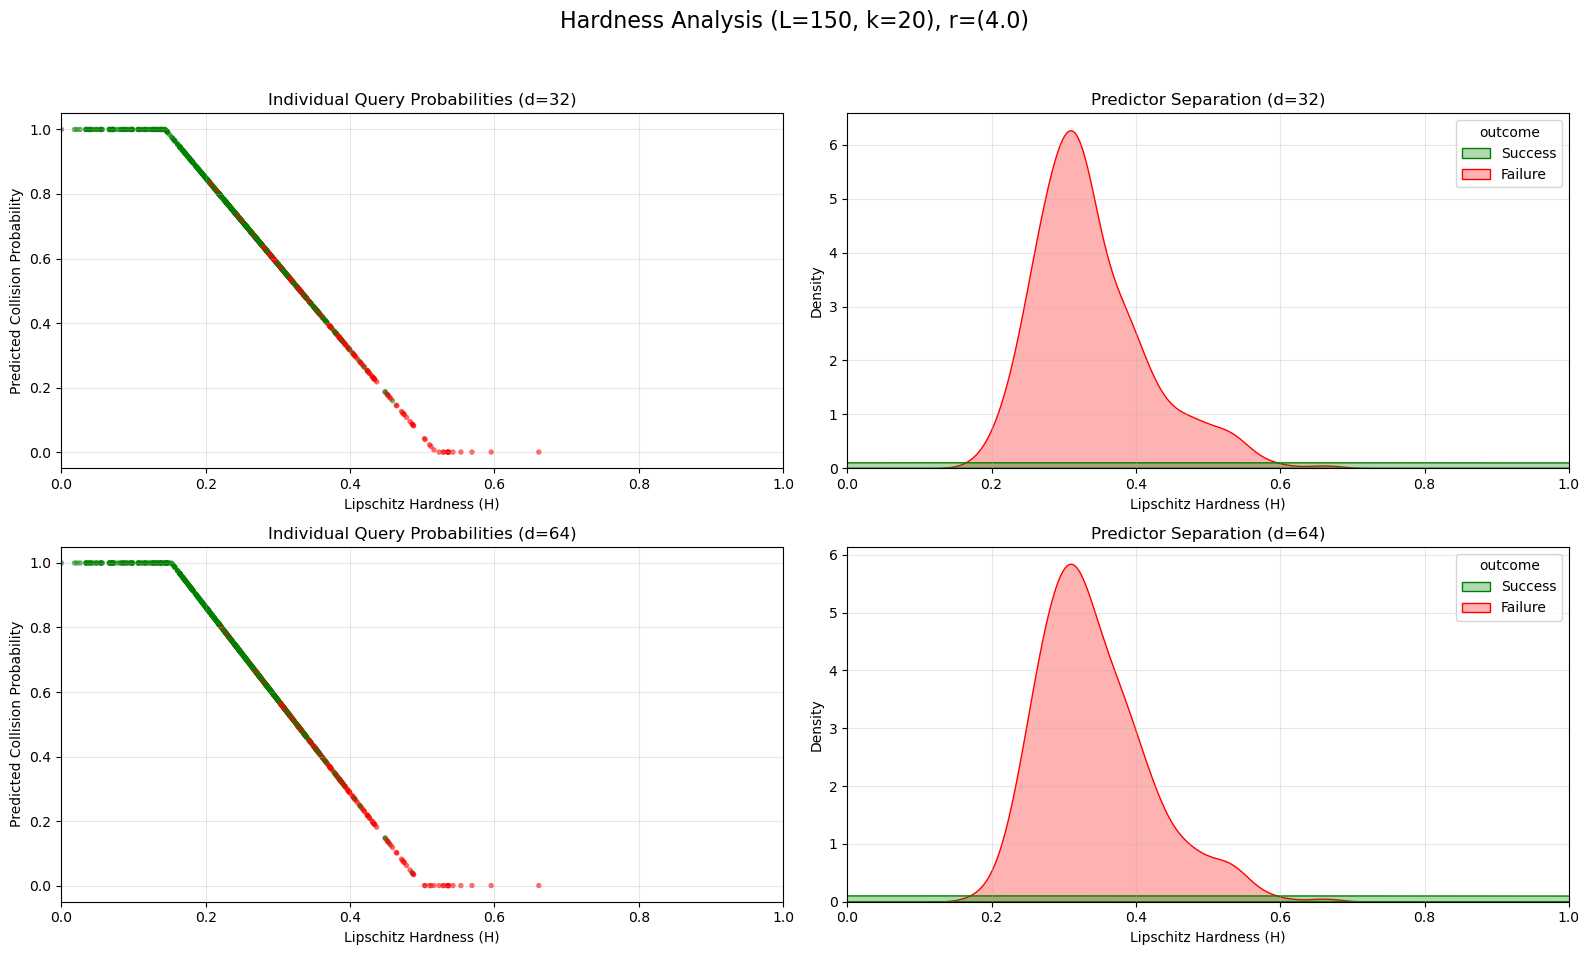

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- Configuration ---
# Ensure we use the full dataset to fit the model, then zoom in for the view
fig, axes = plt.subplots(nrows=len(DIMENSIONS_TO_TEST), ncols=2, figsize=(16, 5 * len(DIMENSIONS_TO_TEST)))
fig.suptitle(f"Hardness Analysis (L={FIXED_L}, k={FIXED_K}), r=({LSH_R})", fontsize=16)

for idx, d in enumerate(DIMENSIONS_TO_TEST):
    df = all_experiment_data[d]
    
    # --- 1. PREPARE PROBABILITY ESTIMATE ---
    # We fit a 2nd degree polynomial to the FULL data to estimate P(Success | Hardness)
    # This gives every individual query a "Collision Probability" value (y-axis)
    poly_coeffs = np.polyfit(df['hardness_H'], df['success'], 2)
    poly_func = np.poly1d(poly_coeffs)
    
    # Calculate predicted prob and clip to [0, 1] range
    df['prob_estimate'] = poly_func(df['hardness_H']).clip(0, 1)
    
    # Create outcome labels for coloring
    df['outcome'] = df['success'].apply(lambda x: 'Success' if x == 1 else 'Failure')
    
    # --- 2. DEFINE ZOOM LIMIT ---
    # Focus on the region where failures occur (99th percentile of failures)
    fail_subset = df[df['success'] == 0]
    if len(fail_subset) > 0:
        zoom_limit = fail_subset['hardness_H'].quantile(0.99) * 1.1
    else:
        zoom_limit = 5.0
    zoom_limit = max(zoom_limit, 1.0) # Lower bound to prevent over-zooming

    # --- Chart 1: Individual Query Probabilities ---
    ax1 = axes[idx][0]
    
    # Filter for plotting (optimization + visual focus)
    df_local = df[df['hardness_H'] <= zoom_limit].copy()
    
    # Scatter Plot:
    # x = Hardness
    # y = Predicted Probability (NOT 0/1 outcome)
    # hue = Actual Outcome (Green/Red)
    sns.scatterplot(
        data=df_local, 
        x='hardness_H', 
        y='prob_estimate', 
        hue='outcome',
        palette={'Success': 'green', 'Failure': 'red'},
        alpha=0.6,  # Semi-transparent to show density
        s=15,       # Small dots
        ax=ax1,
        linewidth=0,
        legend=False # Legend is redundant with right chart
    )
    
    ax1.set_title(f"Individual Query Probabilities (d={d})", fontsize=12)
    ax1.set_xlabel("Lipschitz Hardness (H)")
    ax1.set_ylabel("Predicted Collision Probability")
    ax1.set_ylim(-0.05, 1.05) 
    ax1.set_xlim(0, zoom_limit) 
    ax1.grid(True, alpha=0.3)
    
    # --- Chart 2: Predictor Separation (Density) ---
    ax2 = axes[idx][1]
    
    # Use FULL data for KDE to ensure "Success" curve is calculated correctly (flat), 
    # then zoom the viewport.
    sns.kdeplot(data=df, x='hardness_H', hue='outcome', fill=True, 
                palette={'Success': 'green', 'Failure': 'red'}, 
                alpha=0.3, common_norm=False, ax=ax2)
    
    ax2.set_title(f"Predictor Separation (d={d})", fontsize=12)
    ax2.set_xlabel("Lipschitz Hardness (H)")
    ax2.set_ylabel("Density")
    ax2.set_xlim(0, zoom_limit) 
    ax2.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/var/folders/ry/71dy4f8j4cq06f8_wdgw4_140000gn/T/ipykernel_73855/405090020.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_clean.groupby('bin').agg({'hardness_H': 'mean', 'success': 'mean'}).reset_index()
/var/folders/ry/71dy4f8j4cq06f8_wdgw4_140000gn/T/ipykernel_73855/405090020.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df_clean.groupby('bin').agg({'hardness_H': 'mean', 'success': 'mean'}).reset_index()


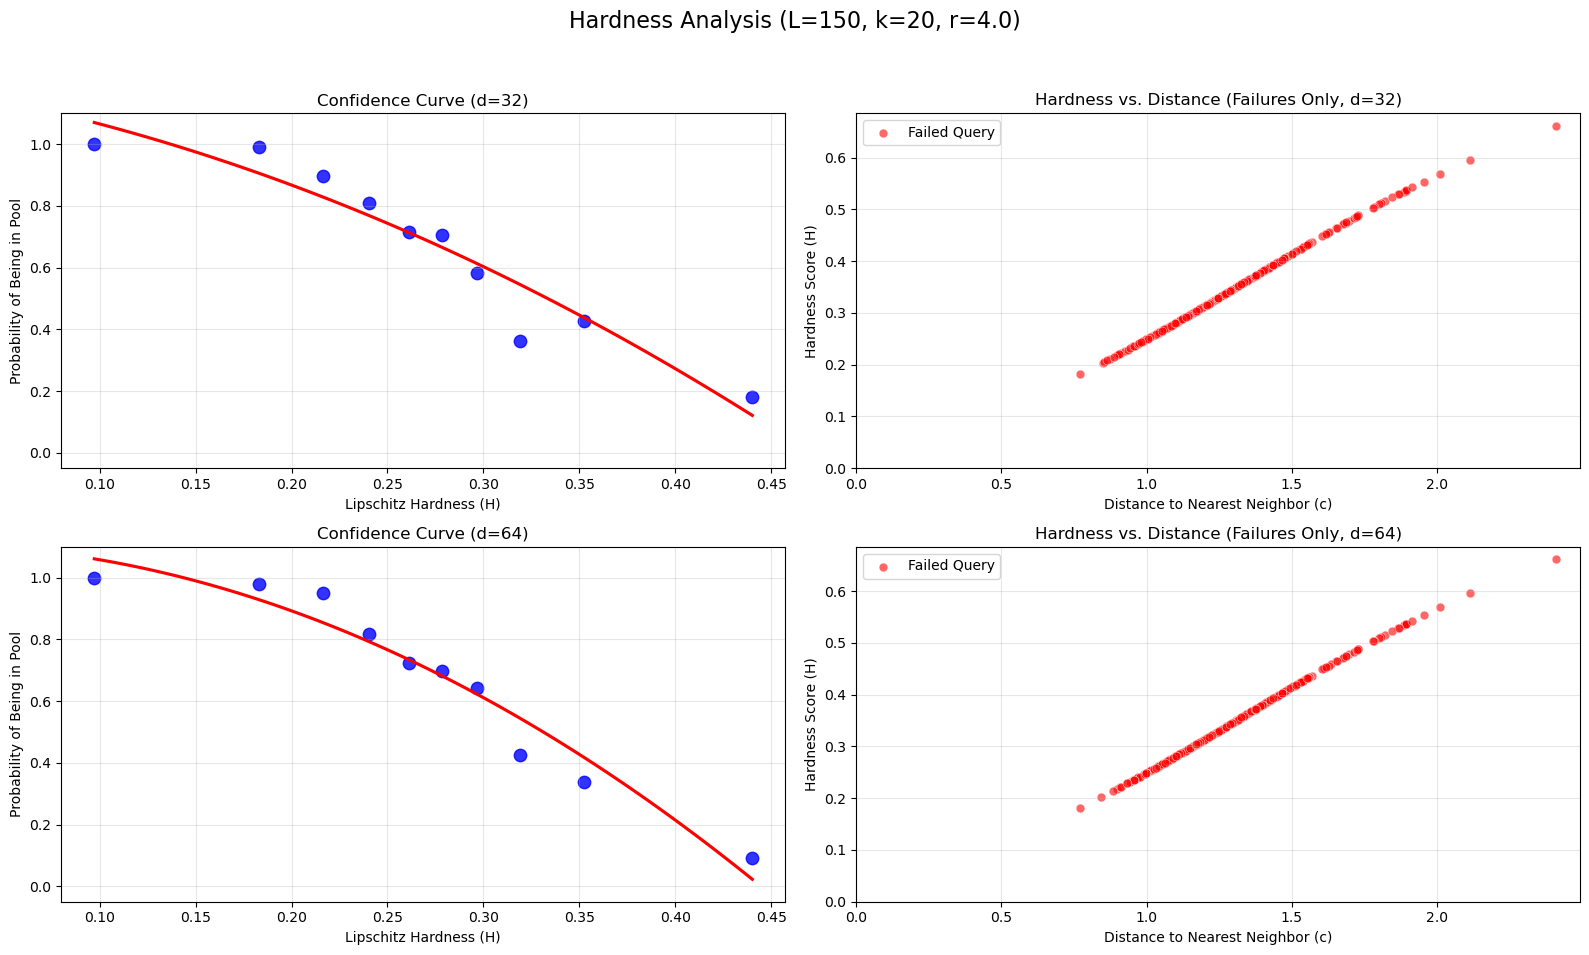

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==========================================
# 1. CONFIGURATION PARAMETERS
# ==========================================


# ==========================================
# 2. GENERATE THE "FULL VISUAL"
# ==========================================
# Calculate dynamic height based on number of dimensions tested
fig, axes = plt.subplots(nrows=len(DIMENSIONS_TO_TEST), ncols=2, 
                         figsize=(16, 5 * len(DIMENSIONS_TO_TEST)))

# Update Title to show ALL parameters (L, k, and r)
fig.suptitle(f"Hardness Analysis (L={FIXED_L}, k={FIXED_K}, r={LSH_R})", fontsize=16)

for idx, d in enumerate(DIMENSIONS_TO_TEST):
    df = all_experiment_data[d]
    
    # --- LEFT CHART: Confidence Curve (Success Rate) ---
    ax1 = axes[idx][0]
    
    # Filter extremes for cleaner polynomial fit
    df_clean = df[df['hardness_H'] < 50].copy() 
    
    # Bin data to get probabilities
    df_clean['bin'] = pd.qcut(df_clean['hardness_H'], q=10, duplicates='drop')
    binned = df_clean.groupby('bin').agg({'hardness_H': 'mean', 'success': 'mean'}).reset_index()
    
    # Plot Trend Line
    sns.regplot(data=binned, x='hardness_H', y='success', order=2, ci=None, 
                scatter_kws={'s': 80, 'color': 'blue'}, 
                line_kws={'color': 'red'}, ax=ax1)
    
    ax1.set_title(f"Confidence Curve (d={d})", fontsize=12)
    ax1.set_xlabel("Lipschitz Hardness (H)")
    ax1.set_ylabel("Probability of Being in Pool")
    ax1.set_ylim(-0.05, 1.1)
    ax1.grid(True, alpha=0.3)
    
    # --- RIGHT CHART: Hardness vs. Distance (Failures Only) ---
    ax2 = axes[idx][1]
    
    # Filter: Only queries that failed (Not in Pool)
    failed_queries = df[df['success'] == 0]
    
    if len(failed_queries) > 0:
        sns.scatterplot(x=failed_queries['true_dist'], y=failed_queries['hardness_H'], 
                        color='red', alpha=0.6, s=40, label='Failed Query', ax=ax2)
    else:
        ax2.text(0.5, 0.5, "No Failures Detected!", 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=ax2.transAxes, fontsize=12, color='green')

    ax2.set_title(f"Hardness vs. Distance (Failures Only, d={d})", fontsize=12)
    ax2.set_xlabel("Distance to Nearest Neighbor (c)")
    ax2.set_ylabel("Hardness Score (H)")
    ax2.grid(True, alpha=0.3)
    
    # FORCE ORIGIN TO (0,0)
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0)
    
    if len(failed_queries) > 0:
        ax2.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for Title
plt.show()

Original Count: 1000
Cleaned Count:  922
Removed 78 outlier(s)


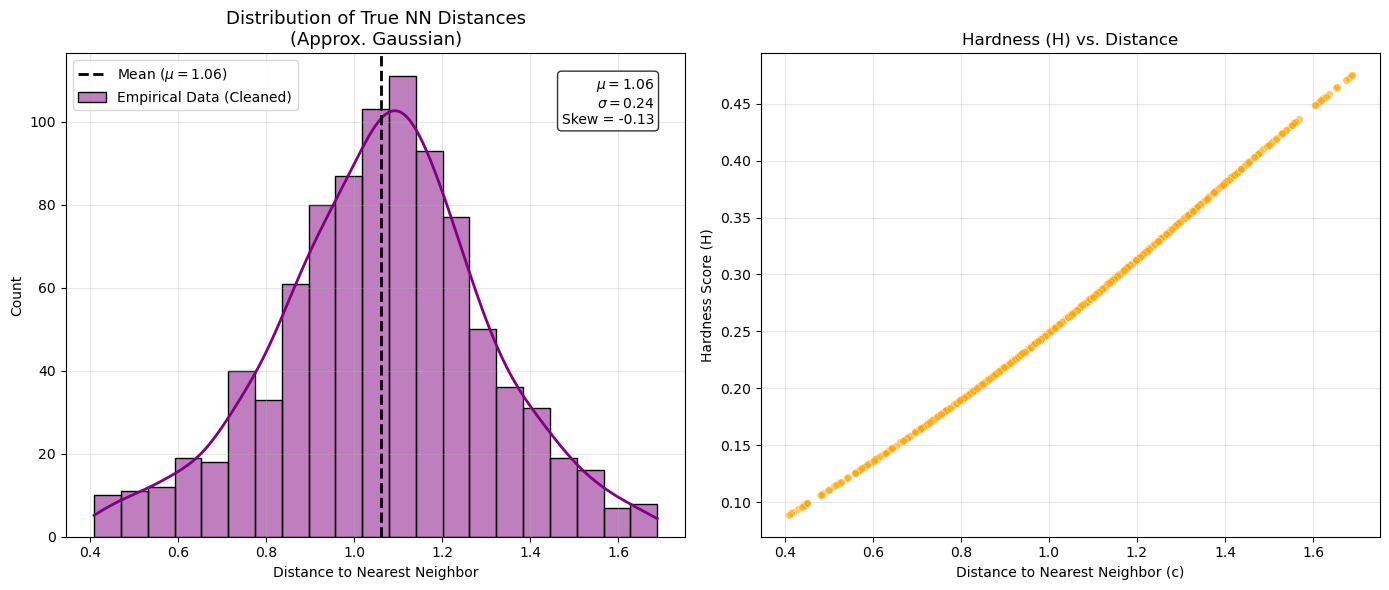

Skewness: -0.1276


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import skew

# Collect data from the first dimension experiment
first_dim = list(all_experiment_data.keys())[0]
raw_dists = all_experiment_data[first_dim]['true_dist']
raw_hardness = all_experiment_data[first_dim]['hardness_H']

# Create a temporary DataFrame to keep dists and hardness aligned
df_temp = pd.DataFrame({'dist': raw_dists, 'hard': raw_hardness})

# ==========================================
# Step 0: Outlier Removal (IQR Method)
# ==========================================
Q1 = df_temp['dist'].quantile(0.25)
Q3 = df_temp['dist'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (standard is 1.5 * IQR, but for "one outlier" we can be strict)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data
df_clean = df_temp[(df_temp['dist'] >= lower_bound) & (df_temp['dist'] <= upper_bound)]

dists = df_clean['dist']
hardness = df_clean['hard']

print(f"Original Count: {len(df_temp)}")
print(f"Cleaned Count:  {len(df_clean)}")
print(f"Removed {len(df_temp) - len(df_clean)} outlier(s)")

# --- Calculate Statistics (On Cleaned Data) ---
mu = np.mean(dists)
sigma = np.std(dists)
skew_val = skew(dists)

plt.figure(figsize=(14, 6))

# ==========================================
# Plot 1: Distance Distribution with Skewness
# ==========================================
plt.subplot(1, 2, 1)

# 1. Plot Histogram & KDE
sns.histplot(dists, kde=True, color='purple', label='Empirical Data (Cleaned)', 
             line_kws={'linewidth': 2})

# 2. Add Mean Line
plt.axvline(mu, color='black', linestyle='--', linewidth=2, 
            label=f'Mean ($\mu={mu:.2f}$)')

# 3. Add Annotations for Stats
stats_text = (f"$\mu = {mu:.2f}$\n"
              f"$\sigma = {sigma:.2f}$\n"
              f"Skew = {skew_val:.2f}")

plt.gca().text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Dynamic Title based on Skew
if abs(skew_val) < 0.5:
    dist_type = "Approx. Gaussian"
elif skew_val > 0:
    dist_type = "Right-Skewed (Positive)"
else:
    dist_type = "Left-Skewed (Negative)"

plt.title(f"Distribution of True NN Distances\n({dist_type})", fontsize=13)
plt.xlabel("Distance to Nearest Neighbor")
plt.ylabel("Count")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# ==========================================
# Plot 2: Hardness vs. Distance (Unchanged)
# ==========================================
plt.subplot(1, 2, 2)
sns.scatterplot(x=dists, y=hardness, color='orange', alpha=0.6, s=30)
plt.title("Hardness (H) vs. Distance")
plt.xlabel("Distance to Nearest Neighbor (c)")
plt.ylabel("Hardness Score (H)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Skewness: {skew_val:.4f}")

## 5. Save Results
We concatenate all results into one CSV for future reference.

In [63]:
df_final = pd.concat(all_experiment_data.values(), ignore_index=True)
save_path = f"results/hardness_analysis_L{FIXED_L}_k{FIXED_K}.csv"

if not os.path.exists('results'):
    os.makedirs('results')

df_final.to_csv(save_path, index=False)
print(f"All per-query results saved to: {save_path}")
display(df_final.head())

All per-query results saved to: results/hardness_analysis_L150_k20.csv


,query_idx,dimension,true_dist,hardness_H,success,outcome_category,pool_size,prob_estimate,outcome
0,0,32,0.753291,0.176830,1,In Pool,-1,0.911864,Success
1,1,32,0.845605,0.202894,1,In Pool,-1,0.842132,Success
2,2,32,0.639633,0.146248,1,In Pool,-1,0.993729,Success
3,3,32,0.991216,0.246373,0,Not in Pool,-1,0.725891,Failure
4,4,32,1.205582,0.315301,0,Not in Pool,-1,0.541822,Failure
